In [11]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import widgets
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [10]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.85,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225  # Air density at sea level (kg/m^3)
}

# Missing energy consumption model

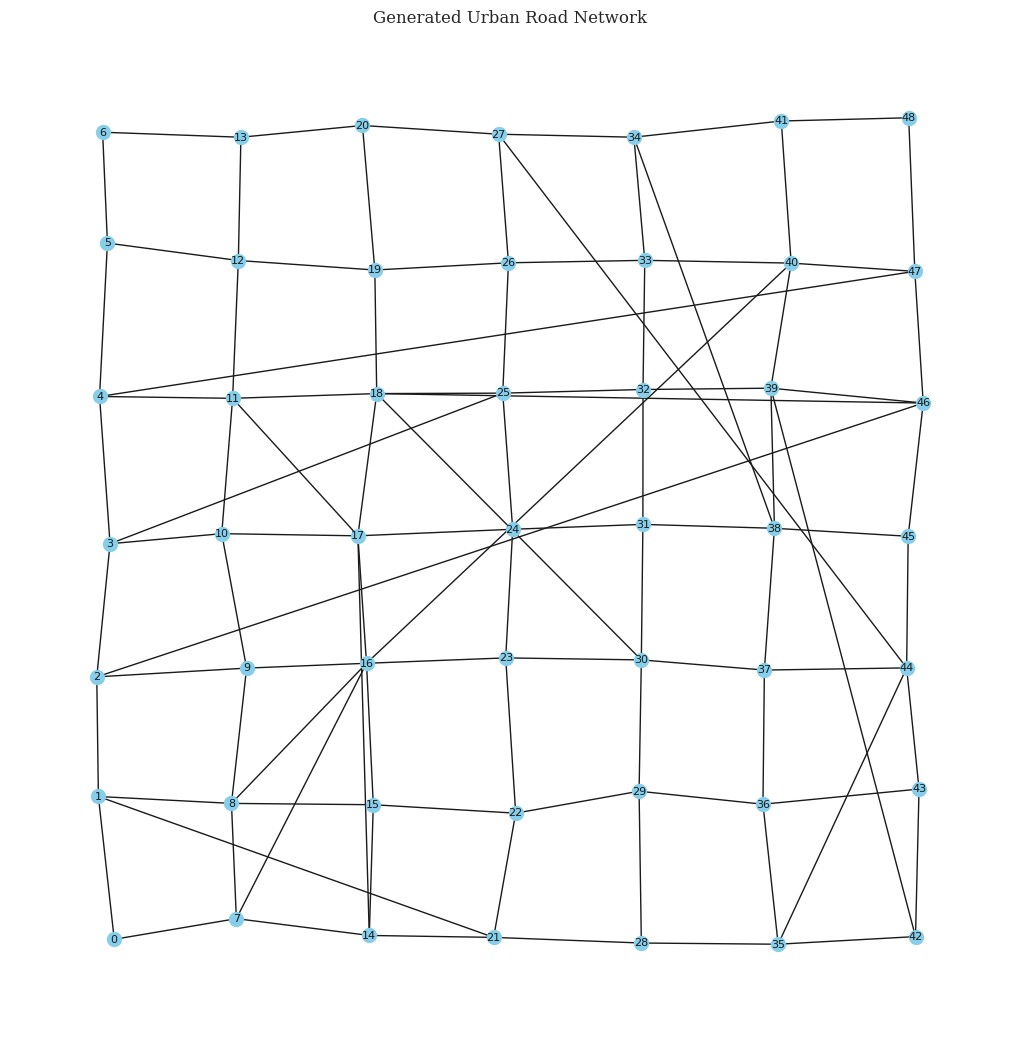




Road Network Statistics:
Number of intersections: 49
Number of roads: 99

=== Random Sample of Road Properties ===

Road #1: 12 → 13
────────────────────────────────────────
  Length:          1526.36 meters
  Speed Limit:     30.0 km/h
  Traffic Density: 0.86 vehicles/km
  Grade:           -2.92%
  Travel Time:     183.16 seconds
────────────────────────────────────────

Road #2: 33 → 34
────────────────────────────────────────
  Length:          1530.35 meters
  Speed Limit:     30.0 km/h
  Traffic Density: 0.39 vehicles/km
  Grade:           1.58%
  Travel Time:     183.64 seconds
────────────────────────────────────────

Road #3: 31 → 32
────────────────────────────────────────
  Length:          1669.84 meters
  Speed Limit:     50.0 km/h
  Traffic Density: 0.49 vehicles/km
  Grade:           1.56%
  Travel Time:     120.23 seconds
────────────────────────────────────────

Road #4: 29 → 36
────────────────────────────────────────
  Length:          1533.38 meters
  Speed Limit:

In [12]:
def generate_road_network(num_nodes=50, num_edges=100):
    """
    Generate a synthetic road network for simulation.

    Parameters:
        num_nodes (int): Number of nodes (intersections)
        num_edges (int): Number of edges (roads)

    Returns:
        nx.Graph: NetworkX graph representing the road network
    """
    # Create a grid-like graph to represent an urban environment
    road_network = nx.grid_2d_graph(int(np.sqrt(num_nodes)), int(np.sqrt(num_nodes)))

    # Convert the grid to a proper road network
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic coordinates to each node
    # Let's assume our city is roughly 10km x 10km
    city_size = 10000  # 10 km in meters
    pos = {}
    grid_size = int(np.sqrt(num_nodes))
    for i in range(num_nodes):
        row = i // grid_size
        col = i % grid_size
        # Add some randomness to make it look more natural
        jitter = np.random.normal(0, 100, 2)  # 100m standard deviation
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]

    # Set node positions as attributes
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add random edges to reach the desired number of edges
    # First, count existing edges
    existing_edges = len(road_network.edges())

    # Add additional edges if needed
    edges_to_add = max(0, num_edges - existing_edges)

    for _ in range(edges_to_add):
        # Select random nodes for a new edge
        node1, node2 = random.sample(list(road_network.nodes()), 2)

        # Skip if edge already exists
        if road_network.has_edge(node1, node2):
            continue

        # Add edge
        road_network.add_edge(node1, node2)

    # Add road properties to edges
    for u, v in road_network.edges():
        # Calculate real distance based on positions
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)

        # Assign attributes based on De Nunzio model requirements
        road_network[u][v]['length'] = distance  # meters
        road_network[u][v]['traffic_density'] = np.random.normal(0.6, 0.1)  # vehicles/km
        road_network[u][v]['speed_limit'] = np.random.choice([30, 40, 50]) * (1000/3600)  # km/h to m/s
        road_network[u][v]['grade'] = np.random.uniform(-0.03, 0.03)  # slope, as a percentage

        # Calculate travel time based on speed and length
        road_network[u][v]['travel_time'] = road_network[u][v]['length'] / road_network[u][v]['speed_limit']

    return road_network

# Generate the road network
city_network = generate_road_network(50, 100)

# Plot the road network
plt.figure(figsize=(10, 10))
pos = nx.get_node_attributes(city_network, 'pos')
nx.draw(city_network, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=8)
plt.title("Generated Urban Road Network")
plt.show()

# Print network stats
print("\n")
print(f"=" * 40)
print(f"\nRoad Network Statistics:")
print(f"Number of intersections: {city_network.number_of_nodes()}")
print(f"Number of roads: {city_network.number_of_edges()}")

# Get 5 random edges
random_edges = random.sample(list(city_network.edges()), 5)

print("\n=== Random Sample of Road Properties ===\n")

for idx, (u, v) in enumerate(random_edges, 1):
    print(f"Road #{idx}: {u} → {v}")
    print("─" * 40)
    print(f"  Length:          {city_network[u][v]['length']:.2f} meters")
    print(f"  Speed Limit:     {city_network[u][v]['speed_limit'] * 3.6:.1f} km/h")
    print(f"  Traffic Density: {city_network[u][v]['traffic_density']:.2f} vehicles/km")
    print(f"  Grade:           {city_network[u][v]['grade'] * 100:.2f}%")
    print(f"  Travel Time:     {city_network[u][v]['travel_time']:.2f} seconds")
    print("─" * 40 + "\n")

In [17]:
def generate_ev_fleet(num_vehicles=100, network=None):
    """
    Generate a fleet of electric vehicles with varying characteristics.

    Parameters:
        num_vehicles (int): Number of EVs to generate
        network (nx.Graph): Road network for initial positioning

    Returns:
        pd.DataFrame: DataFrame containing EV characteristics
    """
    ev_data = {
        'vehicle_id': list(range(1, num_vehicles + 1)),
        'battery_capacity': np.random.uniform(30, 60, num_vehicles),  # kWh
        'energy_consumption': np.random.uniform(0.15, 0.25, num_vehicles),  # kWh/km
        'initial_soc': np.random.uniform(0.2, 0.8, num_vehicles),  # Percentage of battery
        'max_range': [],  # Will be calculated
        'current_position': []  # Node ID in the network
    }

    # Calculate max range based on battery capacity and energy consumption
    for i in range(num_vehicles):
        max_range = ev_data['battery_capacity'][i] / ev_data['energy_consumption'][i]
        ev_data['max_range'].append(max_range)

        # Assign a random node in the network as current position
        if network:
            ev_data['current_position'].append(random.choice(list(network.nodes())))
        else:
            ev_data['current_position'].append(None)

    # Create DataFrame
    ev_fleet = pd.DataFrame(ev_data)

    # Add more vehicle-specific parameters from the existing VEHICLE_PARAMETERS
    for vehicle_id in ev_fleet['vehicle_id']:
        # Slightly vary the parameters for each vehicle
        variation = np.random.uniform(0.9, 1.1)
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'mass'] = VEHICLE_PARAMETERS['mass'] * variation
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'wheel_radius'] = VEHICLE_PARAMETERS['wheel_radius'] * variation
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'drive_efficiency'] = min(1.0, VEHICLE_PARAMETERS['drive_efficiency'] * variation)

    return ev_fleet

def generate_charging_stations(num_stations=10, network=None):
    """
    Generate charging stations across the road network.

    Parameters:
        num_stations (int): Number of charging stations to generate
        network (nx.Graph): Road network for positioning

    Returns:
        pd.DataFrame: DataFrame containing charging station information
    """
    if not network:
        return None

    station_nodes = random.sample(list(network.nodes()), num_stations)

    charging_station_data = {
        'station_id': list(range(1, num_stations + 1)),
        'node_id': station_nodes,
        'capacity': np.random.randint(5, 16, num_stations),  # Number of charging spots
        'power_rating': np.random.choice([50, 100, 150, 250], num_stations),  # kW
        'current_availability': [],  # Will be calculated
        'position': []  # Geographic coordinates
    }

    pos = nx.get_node_attributes(network, 'pos')
    for i, node in enumerate(station_nodes):
        charging_station_data['current_availability'].append(charging_station_data['capacity'][i])
        charging_station_data['position'].append(pos[node])

    charging_stations = pd.DataFrame(charging_station_data)
    return charging_stations

# Generate the EV fleet
ev_fleet = generate_ev_fleet(100, city_network)

# Generate charging stations
charging_stations = generate_charging_stations(10, city_network)

In [21]:
!pip install colorama


📊 Electric Vehicle Fleet Statistics

╒════════════════════════════╤═══════════════╕
│ Number of vehicles         │           100 │
├────────────────────────────┼───────────────┤
│ Average battery capacity   │     45.53 kWh │
├────────────────────────────┼───────────────┤
│ Average energy consumption │ 0.1956 kWh/km │
├────────────────────────────┼───────────────┤
│ Average initial SoC        │         53.4% │
├────────────────────────────┼───────────────┤
│ Average max range          │     237.71 km │
╘════════════════════════════╧═══════════════╛

📊 Charging Station Statistics

╒═════════════════════════╤══════════════╕
│ Number of stations      │           10 │
├─────────────────────────┼──────────────┤
│ Total charging capacity │ 102 vehicles │
├─────────────────────────┼──────────────┤
│ Average power rating    │    125.00 kW │
╘═════════════════════════╧══════════════╛


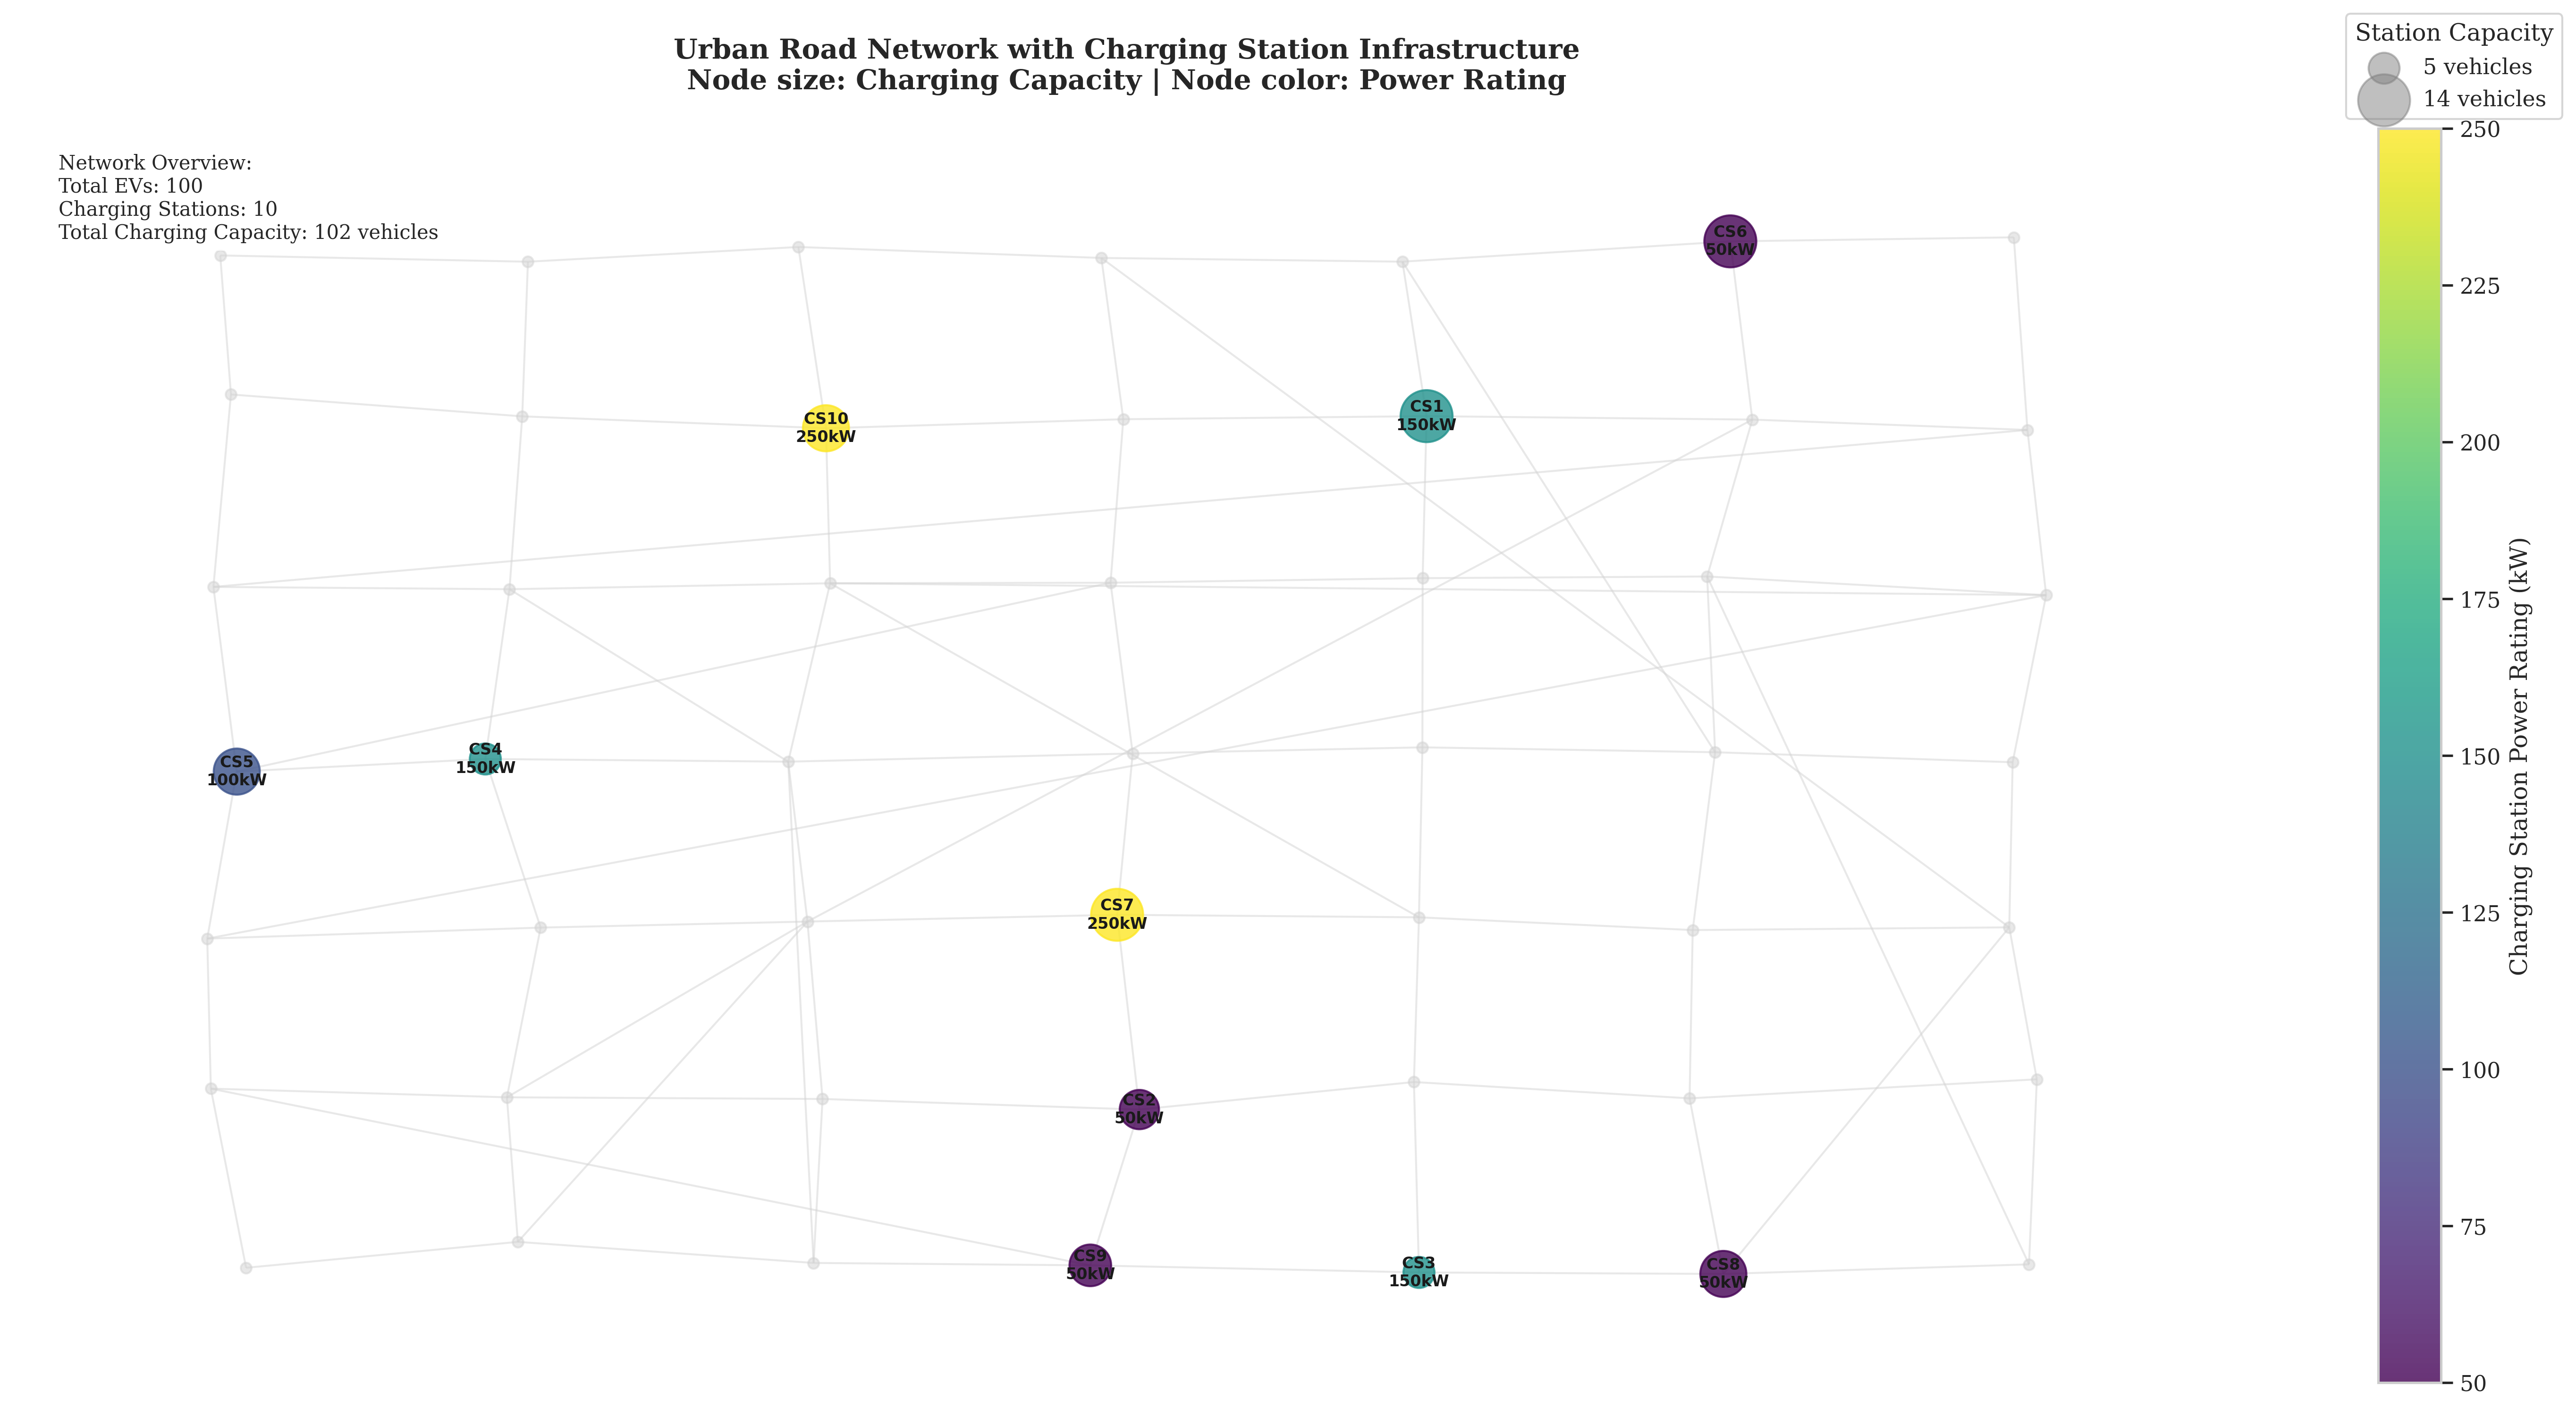

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from colorama import Fore, Style, init

# Initialize colorama
init()

# Create a styled statistics display function
def print_statistics_block(title, stats_dict):
    print(f"\n{Fore.CYAN}{'='*60}")
    print(f"{Fore.WHITE}📊 {title}")
    print(f"{Fore.CYAN}{'='*60}{Style.RESET_ALL}\n")

    data = [[k, v] for k, v in stats_dict.items()]
    print(tabulate(data,
                  tablefmt="fancy_grid",
                  colalign=("left", "right")))

# EV Fleet Statistics
ev_stats = {
    "Number of vehicles": f"{len(ev_fleet)}",
    "Average battery capacity": f"{ev_fleet['battery_capacity'].mean():.2f} kWh",
    "Average energy consumption": f"{ev_fleet['energy_consumption'].mean():.4f} kWh/km",
    "Average initial SoC": f"{(ev_fleet['initial_soc'].mean() * 100):.1f}%",
    "Average max range": f"{ev_fleet['max_range'].mean():.2f} km"
}

# Charging Station Statistics
cs_stats = {
    "Number of stations": f"{len(charging_stations)}",
    "Total charging capacity": f"{charging_stations['capacity'].sum()} vehicles",
    "Average power rating": f"{charging_stations['power_rating'].mean():.2f} kW"
}

# Print statistics
print_statistics_block("Electric Vehicle Fleet Statistics", ev_stats)
print_statistics_block("Charging Station Statistics", cs_stats)

# Create enhanced visualization
plt.figure(figsize=(20, 10), dpi=300)
# plt.style.use('whitegrid')

# Get node positions
pos = nx.get_node_attributes(city_network, 'pos')

# Draw base network
nx.draw_networkx_edges(city_network, pos,
                      edge_color='lightgray',
                      alpha=0.5,
                      width=1)

# Draw regular nodes
regular_nodes = list(set(city_network.nodes()) - set(charging_stations['node_id']))
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=regular_nodes,
                      node_size=30,
                      node_color='lightgray',
                      alpha=0.5)

# Draw charging stations with a more sophisticated style
station_nodes = charging_stations['node_id'].tolist()
station_sizes = charging_stations['capacity'] * 50  # Scale node size by capacity
station_colors = charging_stations['power_rating']  # Color by power rating

nodes = nx.draw_networkx_nodes(city_network, pos,
                             nodelist=station_nodes,
                             node_size=station_sizes,
                             node_color=station_colors,
                             cmap=plt.cm.viridis,
                             alpha=0.8)

# Add colorbar
plt.colorbar(nodes, label='Charging Station Power Rating (kW)')

# Add labels for charging stations
station_labels = {node: f"CS{i+1}\n{charging_stations['power_rating'].iloc[i]:.0f}kW"
                 for i, node in enumerate(station_nodes)}
nx.draw_networkx_labels(city_network, pos,
                       labels=station_labels,
                       font_size=8,
                       font_weight='bold')

# Enhance the plot with titles and labels
plt.title("Urban Road Network with Charging Station Infrastructure\n" +
          "Node size: Charging Capacity | Node color: Power Rating",
          fontsize=14, pad=20, fontweight='bold')

# Add legend for node sizes
sizes = [min(station_sizes), max(station_sizes)]
labels = [f"{min(charging_stations['capacity'])} vehicles",
          f"{max(charging_stations['capacity'])} vehicles"]
legend_elements = [plt.scatter([], [], s=s, c='gray', alpha=0.5, label=l)
                  for s, l in zip(sizes, labels)]
plt.legend(handles=legend_elements, title="Station Capacity",
          loc='upper right', bbox_to_anchor=(1.15, 1.1))

# Remove axes
plt.axis('off')

# Add network statistics as text
stats_text = (f"Network Overview:\n"
              f"Total EVs: {len(ev_fleet)}\n"
              f"Charging Stations: {len(charging_stations)}\n"
              f"Total Charging Capacity: {charging_stations['capacity'].sum()} vehicles")
plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [24]:
def generate_renewable_energy_data(days=7, time_step_minutes=60):
    """
    Generate renewable energy availability data.

    Parameters:
        days (int): Number of days to simulate
        time_step_minutes (int): Time resolution in minutes

    Returns:
        pd.DataFrame: DataFrame containing renewable energy data
    """
    # Calculate number of time steps
    total_minutes = days * 24 * 60
    num_steps = total_minutes // time_step_minutes

    # Create time index
    start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    time_index = [start_time + timedelta(minutes=i*time_step_minutes) for i in range(num_steps)]

    # Calculate hour of day for each time step (0-23)
    hours = [(t.hour + t.minute/60) for t in time_index]

    # Generate solar energy availability (peak at noon)
    solar_energy = []
    for hour in hours:
        if 6 <= hour <= 18:  # Daylight hours
            # Sinusoidal pattern peaking at noon
            solar_value = 5 * np.sin(np.pi * (hour - 6) / 12)
            solar_energy.append(max(0, solar_value))
        else:
            solar_energy.append(0)  # No solar at night

    # Generate wind energy with more randomness (peak in evening)
    wind_energy = []
    for hour in hours:
        # Base pattern with evening peak
        base_wind = 1.5 + 1.5 * np.sin(np.pi * (hour - 12) / 12)
        # Add randomness
        random_factor = np.random.normal(1, 0.3)
        wind_value = max(0, base_wind * random_factor)
        wind_energy.append(wind_value)

    # Calculate grid demand and price
    grid_demand = []
    grid_price = []

    for hour in hours:
        # Morning peak (7-9am) and evening peak (5-8pm)
        if (7 <= hour <= 9) or (17 <= hour <= 20):
            base_demand = np.random.uniform(0.8, 1.0)  # High demand
            price = np.random.uniform(0.15, 0.25)  # Higher price
        elif 23 <= hour or hour <= 5:  # Night (11pm-5am)
            base_demand = np.random.uniform(0.3, 0.5)  # Low demand
            price = np.random.uniform(0.05, 0.08)  # Lower price
        else:  # Rest of day
            base_demand = np.random.uniform(0.5, 0.7)  # Medium demand
            price = np.random.uniform(0.10, 0.15)  # Medium price

        # Add some day-to-day variation
        day_factor = 1 + 0.1 * np.sin(2 * np.pi * (time_index[hours.index(hour)].day % 7) / 7)
        grid_demand.append(base_demand * day_factor)
        grid_price.append(price * day_factor)

    # Generate V2G incentives based on grid demand
    v2g_price = [price * 1.2 if demand > 0.7 else price * 0.8 for price, demand in zip(grid_price, grid_demand)]

    # Create DataFrame
    data = {
        'time': time_index,
        'solar_energy_kW': solar_energy,
        'wind_energy_kW': wind_energy,
        'total_renewable_kW': [s + w for s, w in zip(solar_energy, wind_energy)],
        'grid_demand': grid_demand,  # normalized between 0 and 1
        'grid_price_USD_per_kWh': grid_price,
        'v2g_price_USD_per_kWh': v2g_price
    }

    renewable_data = pd.DataFrame(data)
    return renewable_data

def define_green_zones(network, renewable_data, num_green_zones=5):
    """
    Define green zones in the network based on renewable energy availability.

    Parameters:
        network (nx.Graph): Road network
        renewable_data (pd.DataFrame): Renewable energy data
        num_green_zones (int): Number of green zones to define

    Returns:
        list: List of node IDs that are green zones
    """
    # Select nodes with high potential for renewable energy (simplified approach)
    green_zone_nodes = random.sample(list(network.nodes()), num_green_zones)

    # Set attribute in network
    for node in network.nodes():
        if node in green_zone_nodes:
            network.nodes[node]['is_green_zone'] = True
        else:
            network.nodes[node]['is_green_zone'] = False

    return green_zone_nodes

# Generate renewable energy data for a week with hourly resolution
renewable_energy_data = generate_renewable_energy_data(7, 60)

# Define green zones in the network
green_zones = define_green_zones(city_network, renewable_energy_data, 5)




⚡ Renewable Energy System Statistics

╒═══════════════════════╤════════════════════════════════════════════╕
│ Metric                │                                      Value │
╞═══════════════════════╪════════════════════════════════════════════╡
│ Time Range            │ 2025-03-08 00:00:00 to 2025-03-14 23:00:00 │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Solar Energy  │                                    1.58 kW │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Wind Energy   │                                    1.51 kW │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Grid Price    │                            $0.1395 per kWh │
├───────────────────────┼────────────────────────────────────────────┤
│ Average V2G Incentive │                            $0.1418 per kWh │
╘═══════════════════════╧════════════════════════════════════════════╛


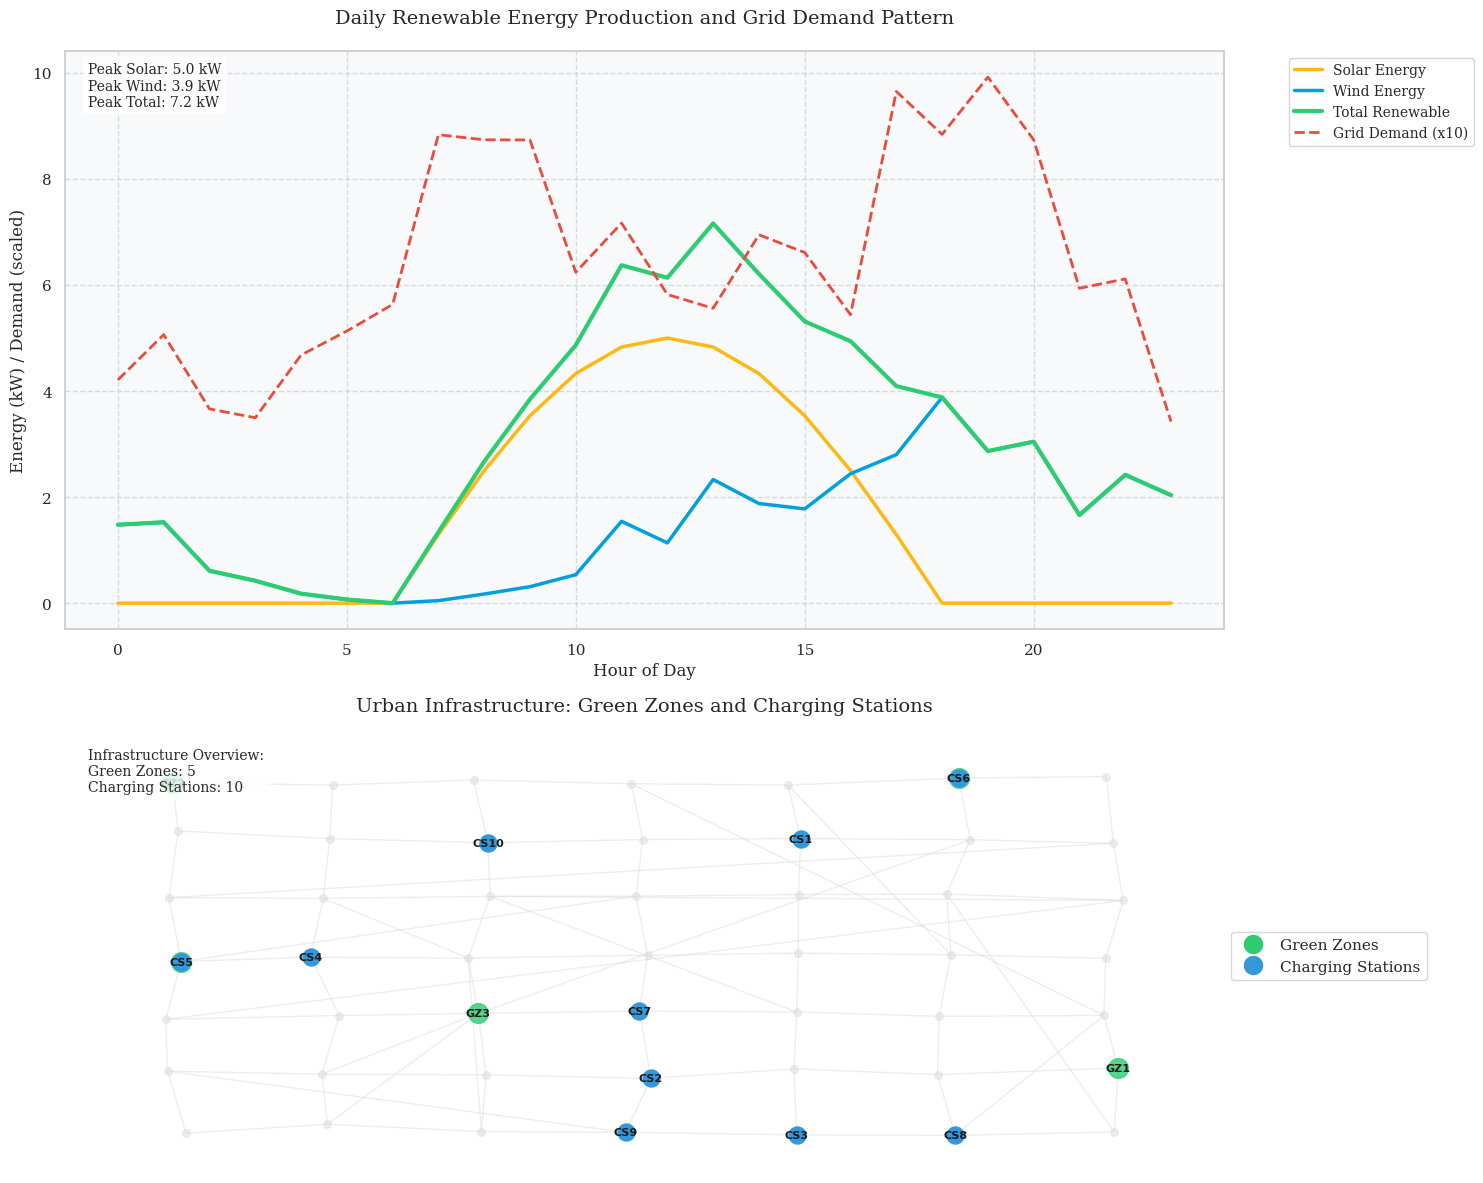

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tabulate import tabulate
from colorama import Fore, Style, init
import matplotlib.dates as mdates

# Initialize colorama
init()

# Function to display statistics in a formatted table
def print_energy_statistics(data):
    print(f"\n{Fore.CYAN}{'='*60}")
    print(f"{Fore.WHITE}⚡ Renewable Energy System Statistics")
    print(f"{Fore.CYAN}{'='*60}{Style.RESET_ALL}\n")

    stats = [
        ["Time Range", f"{data['time'].min()} to {data['time'].max()}"],
        ["Average Solar Energy", f"{data['solar_energy_kW'].mean():.2f} kW"],
        ["Average Wind Energy", f"{data['wind_energy_kW'].mean():.2f} kW"],
        ["Average Grid Price", f"${data['grid_price_USD_per_kWh'].mean():.4f} per kWh"],
        ["Average V2G Incentive", f"${data['v2g_price_USD_per_kWh'].mean():.4f} per kWh"]
    ]

    print(tabulate(stats,
                  headers=["Metric", "Value"],
                  tablefmt="fancy_grid",
                  colalign=("left", "right")))

# Display statistics
print_energy_statistics(renewable_energy_data)

# Create figure with subplots
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(2, 1, height_ratios=[2, 1.5])

# Plot 1: Energy Production and Demand
ax1 = fig.add_subplot(gs[0])
sample_data = renewable_energy_data.iloc[:24]
hours = range(24)

# Plot with enhanced styling
ax1.plot(hours, sample_data['solar_energy_kW'],
         label='Solar Energy', color='#FDB813', linewidth=2.5)
ax1.plot(hours, sample_data['wind_energy_kW'],
         label='Wind Energy', color='#00A0DC', linewidth=2.5)
ax1.plot(hours, sample_data['total_renewable_kW'],
         label='Total Renewable', color='#2ECC71', linewidth=3)
ax1.plot(hours, sample_data['grid_demand'] * 10,
         label='Grid Demand (x10)', color='#E74C3C',
         linestyle='--', linewidth=2)

# Enhance grid and styling
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Energy (kW) / Demand (scaled)', fontsize=12)
ax1.set_title('Daily Renewable Energy Production and Grid Demand Pattern',
              fontsize=14, pad=20)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.set_facecolor('#f8f9fa')

# Add summary statistics
stats_text = (f"Peak Solar: {sample_data['solar_energy_kW'].max():.1f} kW\n"
              f"Peak Wind: {sample_data['wind_energy_kW'].max():.1f} kW\n"
              f"Peak Total: {sample_data['total_renewable_kW'].max():.1f} kW")
ax1.text(0.02, 0.98, stats_text,
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Plot 2: Network with Green Zones and Charging Stations
ax2 = fig.add_subplot(gs[1])
pos = nx.get_node_attributes(city_network, 'pos')

# Draw base network with enhanced styling
nx.draw_networkx_edges(city_network, pos,
                      edge_color='#dcdcdc',
                      alpha=0.5,
                      width=1,
                      ax=ax2)

# Draw regular nodes
regular_nodes = list(set(city_network.nodes()) - set(green_zones) - set(charging_stations['node_id']))
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=regular_nodes,
                      node_size=30,
                      node_color='#dcdcdc',
                      alpha=0.5,
                      ax=ax2)

# Draw green zones with gradient color
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=green_zones,
                      node_color='#2ECC71',
                      node_size=200,
                      alpha=0.8,
                      ax=ax2)

# Draw charging stations
charging_nodes = charging_stations['node_id'].tolist()
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=charging_nodes,
                      node_color='#3498DB',
                      node_size=150,
                      ax=ax2)

# Add labels with better formatting
green_zone_labels = {node: f"GZ{i+1}" for i, node in enumerate(green_zones)}
station_labels = {node: f"CS{i+1}" for i, node in enumerate(charging_nodes)}
labels = {**green_zone_labels, **station_labels}
nx.draw_networkx_labels(city_network, pos,
                       labels=labels,
                       font_size=8,
                       font_weight='bold',
                       ax=ax2)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor='#2ECC71', markersize=15, label='Green Zones'),
                  plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor='#3498DB', markersize=15, label='Charging Stations')]
ax2.legend(handles=legend_elements,
          loc='center left',
          bbox_to_anchor=(1, 0.5))

ax2.set_title('Urban Infrastructure: Green Zones and Charging Stations',
              fontsize=14, pad=20)
ax2.axis('off')

# Add network statistics
network_stats = (f"Infrastructure Overview:\n"
                f"Green Zones: {len(green_zones)}\n"
                f"Charging Stations: {len(charging_stations)}")
ax2.text(0.02, 0.98, network_stats,
         transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [26]:
def bellman_ford_energy_routing(network, origin, destination, vehicle_params):
    """
    Implements Bellman-Ford algorithm to find the shortest path based solely on energy consumption.

    Parameters:
        network (nx.Graph): Road network
        origin (int): Origin node ID
        destination (int): Destination node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        list: Route with minimal energy consumption
    """
    # Create a directed graph for Bellman-Ford
    energy_graph = nx.DiGraph()

    # Add all nodes from the original graph
    for node in network.nodes():
        energy_graph.add_node(node)

    # Calculate energy weights for each edge
    for u, v in network.edges():
        edge_data = network[u][v]
        section = {
            "summary": {
                "length": edge_data['length'],
                "duration": edge_data['travel_time']
            },
            "grade": edge_data.get('grade', 0),
            "acceleration": 0
        }
        energy = compute_energy_consumption([section], vehicle_params)[0]
        energy_graph.add_edge(u, v, weight=energy)

    # Run Bellman-Ford algorithm
    try:
        # Get the path and distances using Bellman-Ford
        distance, path = nx.single_source_bellman_ford(energy_graph, origin, target=destination, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None

In [27]:
class AntColonyOptimization:
    """
    Ant Colony Optimization for route finding that maximizes incentives and greenzone compliance
    while minimizing energy consumption and penalties.
    """

    def __init__(self, network, vehicle_params, renewable_data, current_time=None,
                 n_ants=10, n_iterations=20, alpha=1.0, beta=2.0, rho=0.5, q0=0.9):
        """
        Initialize ACO algorithm parameters.

        Parameters:
            network (nx.Graph): Road network
            vehicle_params (dict): Vehicle parameters
            renewable_data (pd.DataFrame): Renewable energy data
            current_time (datetime): Current simulation time
            n_ants (int): Number of ants
            n_iterations (int): Number of iterations
            alpha (float): Pheromone importance factor
            beta (float): Heuristic importance factor
            rho (float): Evaporation rate
            q0 (float): Exploration/exploitation balance factor
        """
        self.network = network
        self.vehicle_params = vehicle_params
        self.renewable_data = renewable_data
        self.current_time = current_time if current_time else datetime.now()
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0

        # Initialize pheromone trails
        self.pheromones = {}
        for u, v in network.edges():
            self.pheromones[(u, v)] = 1.0

        # Create node neighbor dictionary for faster access
        self.neighbors = {node: list(network.neighbors(node)) for node in network.nodes()}

    def get_edge_attractiveness(self, u, v):
        """Calculate the heuristic attractiveness of an edge based on multiple factors"""
        edge_data = self.network[u][v]

        # Calculate energy consumption for this edge
        section = {
            "summary": {
                "length": edge_data['length'],
                "duration": edge_data['travel_time']
            },
            "grade": edge_data.get('grade', 0),
            "acceleration": 0
        }
        energy = compute_energy_consumption([section], self.vehicle_params)[0] / 3_600_000  # J to kWh

        # Incentive factor (higher is better)
        incentive_factor = 1.0
        if self.network.nodes[v].get('is_green_zone', False):
            incentive_factor = 3.0  # Prefer green zones

        # Time factor (lower is better)
        time_factor = 1.0 / max(edge_data['travel_time'], 1.0)

        # Combined heuristic: favor low energy, high incentives, and reasonable time
        # Higher value = more attractive edge
        return incentive_factor * time_factor / max(energy, 0.01)

    def select_next_node(self, ant, current_node, destination):
        """Select next node for an ant to visit using ACO rules"""
        if current_node == destination:
            return None

        available_neighbors = [n for n in self.neighbors[current_node]
                              if n not in ant['visited'] or n == destination]

        if not available_neighbors:
            return None

        # Calculate probabilities for available neighbors
        attractions = []
        for neighbor in available_neighbors:
            pheromone = self.pheromones.get((current_node, neighbor), 0.1)
            attraction = self.get_edge_attractiveness(current_node, neighbor)
            attractions.append((pheromone ** self.alpha) * (attraction ** self.beta))

        # Normalize probabilities
        total = sum(attractions)
        probabilities = [attr / total for attr in attractions] if total > 0 else [1.0 / len(available_neighbors)] * len(available_neighbors)

        # Exploration vs exploitation
        if random.random() < self.q0:
            # Exploitation: choose best
            best_idx = np.argmax(attractions)
            return available_neighbors[best_idx]
        else:
            # Exploration: probabilistic choice
            return random.choices(available_neighbors, weights=probabilities, k=1)[0]

    def calculate_route_quality(self, route):
        """Calculate the quality of a route based on objectives"""
        if len(route) <= 1:
            return 0

        # Calculate metrics
        energy_consumption = calculate_energy_consumption(route, self.network, self.vehicle_params)
        v2g_incentives = calculate_v2g_incentives(route, self.network, self.renewable_data, self.current_time)
        green_zone_compliance = calculate_green_zone_compliance(route, self.network)

        # Calculate penalties
        penalty = 0
        if green_zone_compliance < 10:  # Penalty if green zone compliance is too low
            penalty = 2.0

        # Calculate combined quality (higher is better)
        # We want to minimize energy and penalties, maximize incentives and green zone compliance
        quality = (v2g_incentives + (green_zone_compliance/10)) / (max(energy_consumption, 0.1) + penalty)

        return quality

    def update_pheromones(self, all_routes, all_qualities):
        """Update pheromone trails based on route qualities"""
        # Evaporate existing pheromones
        for edge in self.pheromones:
            self.pheromones[edge] *= (1 - self.rho)

        # Add new pheromones based on route quality
        for route, quality in zip(all_routes, all_qualities):
            for i in range(len(route) - 1):
                u, v = route[i], route[i + 1]
                if (u, v) in self.pheromones:
                    self.pheromones[(u, v)] += quality

    def find_route(self, origin, destination):
        """Find the best route using ACO"""
        best_route = None
        best_quality = -float('inf')

        # Use Dijkstra as initial heuristic
        try:
            initial_path = nx.shortest_path(self.network, origin, destination, weight='travel_time')
            best_route = initial_path
            best_quality = self.calculate_route_quality(initial_path)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None

        for iteration in range(self.n_iterations):
            all_routes = []
            all_qualities = []

            for ant in range(self.n_ants):
                current_path = [origin]
                current_node = origin
                visited = {origin}

                # Build route
                while current_node != destination:
                    next_node = self.select_next_node(
                        {'visited': visited},
                        current_node,
                        destination
                    )

                    if next_node is None:
                        break

                    current_path.append(next_node)
                    visited.add(next_node)
                    current_node = next_node

                # Check if route is valid and complete
                if current_path[-1] == destination:
                    route_quality = self.calculate_route_quality(current_path)
                    all_routes.append(current_path)
                    all_qualities.append(route_quality)

                    # Update best route if needed
                    if route_quality > best_quality:
                        best_route = current_path.copy()
                        best_quality = route_quality

            # Update pheromones if we have valid routes
            if all_routes:
                self.update_pheromones(all_routes, all_qualities)

        return best_route

In [28]:
def hybrid_dijkstra_aco_routing(network, origin, destination, vehicle_params, renewable_data, current_time=None):
    """
    Implements a hybrid Dijkstra + ACO routing algorithm that considers incentives,
    penalties and greenzone compliance.

    Parameters:
        network (nx.Graph): Road network
        origin (int): Origin node ID
        destination (int): Destination node ID
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        list: Optimized route
    """
    # Initialize ACO with parameters
    aco = AntColonyOptimization(
        network=network,
        vehicle_params=vehicle_params,
        renewable_data=renewable_data,
        current_time=current_time,
        n_ants=15,
        n_iterations=30
    )

    # Find route using ACO
    route = aco.find_route(origin, destination)

    return route

In [29]:
def calculate_energy_consumption(route, network, vehicle_params):
    """
    Calculate energy consumption for a given route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters

    Returns:
        float: Energy consumption in kWh
    """
    # Use the compute_energy_consumption function from the existing implementation
    route_sections = []

    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]

        if (u, v) in network.edges():
            edge_data = network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0  # Assume constant speed
            }
            route_sections.append(section)

    energy_consumption = compute_energy_consumption(route_sections, vehicle_params)
    return sum(energy_consumption) / 3_600_000  # Convert from J to kWh

def calculate_v2g_incentives(route, network, renewable_data, current_time=None):
    """
    Calculate V2G incentives for a given route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        float: V2G incentives in USD
    """
    if current_time is None:
        current_time = datetime.now()

    # Find the closest time in renewable_data
    time_diff = [(t - current_time).total_seconds() for t in renewable_data['time']]
    closest_idx = time_diff.index(min([abs(td) for td in time_diff]))

    # Get V2G price at the current time
    v2g_price = renewable_data.iloc[closest_idx]['v2g_price_USD_per_kWh']

    # Estimate potential V2G discharge capacity (simplified)
    # Assume 10% of battery capacity is available for V2G if we pass through a green zone
    v2g_energy = 0
    for node in route:
        if network.nodes[node].get('is_green_zone', False):
            # For simplicity, assume 2 kWh is available for grid support at each green zone
            v2g_energy += 2

    # Calculate incentive
    v2g_incentive = v2g_price * v2g_energy

    return v2g_incentive

def calculate_travel_time(route, network):
    """
    Calculate the total travel time for a route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network

    Returns:
        float: Travel time in minutes
    """
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if (u, v) in network.edges():
            total_time += network[u][v]['travel_time']

    return total_time / 60  # Convert from seconds to minutes

def calculate_green_zone_compliance(route, network):
    """
    Calculate the percentage of the route that passes through GreenZones.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network

    Returns:
        float: Percentage of route through GreenZones
    """
    green_zone_nodes = [node for node in network.nodes() if network.nodes[node].get('is_green_zone', False)]

    # Count green zone nodes in route
    green_nodes_in_route = sum(1 for node in route if node in green_zone_nodes)

    # Calculate percentage
    if len(route) > 0:
        return (green_nodes_in_route / len(route)) * 100
    else:
        return 0

def calculate_emissions_reduction(route, network, vehicle_params, baseline_emissions=0.2):
    """
    Calculate the reduction in carbon emissions.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        baseline_emissions (float): Baseline emissions in kg CO2/km for conventional vehicles

    Returns:
        float: Emissions reduction in kg CO2
    """
    # Calculate total route length
    total_length = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if (u, v) in network.edges():
            total_length += network[u][v]['length']

    # Convert to kilometers
    total_length_km = total_length / 1000

    # Calculate baseline emissions (conventional vehicle)
    conventional_emissions = total_length_km * baseline_emissions

    # Calculate EV emissions based on energy mix
    # Simplified approach: assume 0.1 kg CO2/kWh for electricity
    ev_energy = calculate_energy_consumption(route, network, vehicle_params)
    ev_emissions = ev_energy * 0.1

    # Calculate reduction
    emissions_reduction = conventional_emissions - ev_emissions

    return emissions_reduction

def calculate_route_cost(route, network, vehicle_params, renewable_data, current_time=None):
    """
    Calculate the total cost of a route including energy, incentives, and penalties.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        float: Total cost in USD
    """
    if current_time is None:
        current_time = datetime.now()

    # Find the closest time in renewable_data
    time_diff = [(t - current_time).total_seconds() for t in renewable_data['time']]
    closest_idx = time_diff.index(min([abs(td) for td in time_diff]))

    # Get energy price at the current time
    energy_price = renewable_data.iloc[closest_idx]['grid_price_USD_per_kWh']

    # Calculate energy consumption cost
    energy_consumption = calculate_energy_consumption(route, network, vehicle_params)
    energy_cost = energy_consumption * energy_price

    # Calculate V2G incentives (negative cost)
    v2g_incentives = calculate_v2g_incentives(route, network, renewable_data, current_time)

    # Green zone penalties (if any) - simplified approach
    green_zone_compliance = calculate_green_zone_compliance(route, network)
    green_zone_penalty = 0
    if green_zone_compliance < 10:  # Arbitrary threshold
        green_zone_penalty = 1.0  # $1 penalty for low green zone compliance

    # Total cost
    total_cost = energy_cost - v2g_incentives + green_zone_penalty

    return total_cost


In [30]:
def evaluate_routing_strategy(origin, destination, network, vehicle_params, renewable_data,
                             strategy='bellman_ford', current_time=None):
    """
    Evaluate a routing strategy using multiple metrics.

    Parameters:
        origin (int): Origin node ID
        destination (int): Destination node ID
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        strategy (str): Routing strategy ('bellman_ford', 'hybrid')
        current_time (datetime): Current simulation time

    Returns:
        dict: Dictionary of evaluation metrics
    """
    # Get route based on strategy
    if strategy == 'bellman_ford':
        # Use Bellman-Ford for minimal energy consumption only
        route = bellman_ford_energy_routing(network, origin, destination, vehicle_params)
    elif strategy == 'hybrid':
        # Use hybrid Dijkstra + ACO for optimizing incentives and green zone compliance
        route = hybrid_dijkstra_aco_routing(network, origin, destination,
                                           vehicle_params, renewable_data, current_time)
    else:
        raise ValueError(f"Unknown routing strategy: {strategy}")

    if route is None:
        return {'Strategy': strategy, 'Error': 'No path found'}

    # Calculate metrics
    energy_consumption = calculate_energy_consumption(route, network, vehicle_params)
    v2g_incentives = calculate_v2g_incentives(route, network, renewable_data, current_time)
    travel_time = calculate_travel_time(route, network)
    green_zone_compliance = calculate_green_zone_compliance(route, network)
    emissions_reduction = calculate_emissions_reduction(route, network, vehicle_params)
    route_cost = calculate_route_cost(route, network, vehicle_params, renewable_data, current_time)

    # Return metrics
    metrics = {
        'Strategy': strategy,
        'Route': route,
        'Energy Consumption (kWh)': energy_consumption,
        'V2G Incentives (USD)': v2g_incentives,
        'Travel Time (minutes)': travel_time,
        'GreenZone Compliance (%)': green_zone_compliance,
        'Emissions Reduction (kg CO2)': emissions_reduction,
        'Route Cost (USD)': route_cost
    }

    return metrics

In [31]:
def compare_routing_strategies(origin, destination, network, vehicle_params, renewable_data, current_time=None):
    """
    Compare different routing strategies for the same origin-destination pair.

    Parameters:
        origin (int): Origin node ID
        destination (int): Destination node ID
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    # Now we compare only the two required strategies
    strategies = ['bellman_ford', 'hybrid']
    results = []

    for strategy in strategies:
        metrics = evaluate_routing_strategy(
            origin, destination, network, vehicle_params, renewable_data, strategy, current_time
        )
        results.append(metrics)

    # Convert to DataFrame for easier comparison
    comparison_df = pd.DataFrame(results)

    # Drop the actual route column for display purposes
    if 'Route' in comparison_df.columns:
        comparison_df = comparison_df.drop('Route', axis=1)

    return comparison_df

# Assume that compute_energy_consumption function is defined elsewhere
def compute_energy_consumption(route_sections, vehicle_params):
    """
    Placeholder for the compute_energy_consumption function.
    In a real implementation, this would be imported from the physics module.

    Parameters:
        route_sections (list): List of route sections
        vehicle_params (dict): Vehicle parameters

    Returns:
        list: Energy consumption values in Joules for each section
    """
    # This is a simplified placeholder - in reality, you would use your actual implementation
    result = []
    for section in route_sections:
        # Simple energy model: E = mass * g * elevation + 0.5 * rho * Cd * A * v²
        length = section["summary"]["length"]  # meters
        grade = section.get("grade", 0)  # elevation change as a fraction
        elevation = length * grade  # approximate elevation change in meters

        # Basic physics model (extremely simplified)
        mass = vehicle_params.get("mass", 2000)  # kg
        g = 9.81  # m/s²
        rho = 1.225  # kg/m³ (air density)
        Cd = vehicle_params.get("drag_coefficient", 0.3)
        A = vehicle_params.get("frontal_area", 2.5)  # m²

        # Calculate average speed from length and duration
        duration = section["summary"]["duration"]  # seconds
        v = length / max(duration, 1)  # m/s

        # Basic energy calculation (in Joules)
        potential_energy = mass * g * max(elevation, 0)  # Only consider uphill
        kinetic_energy = 0.5 * rho * Cd * A * (v**2) * length

        # Apply regenerative braking for downhill (simplified: 50% recovery)
        regenerative_energy = 0
        if elevation < 0:
            regenerative_energy = 0.5 * mass * g * abs(elevation)

        # Total energy consumption for this section
        section_energy = potential_energy + kinetic_energy - regenerative_energy
        result.append(max(section_energy, 10))  # Ensure positive energy consumption

    return result